# Chapter 7

## 7.1 The problem with parameters
## 7.2 Accuracy and Entropy
## 7.3 Regularization
## 7.4 Predicting Predictive Accuracy
## 7.5 Model comparison

## Intro
+ OKHAM'S RAZOR - Models with fewer assumptions are to be preferrred
+ Have to tradeoff between model simplicity and model accuracy
+ OVERFITTING - poor prediction from over-learning the data
+ UNDERFITTING - Poor prediction by under-learning the data
+ Confounded models can produce better predictions than correct causal models.
+ In designing a model, we need to choose between understanding causes, and just predicting
+ But a causal model can suffer from over/underfitting
+ Two approaches to trading off under/overfitting
    + REGULARIZING PRIOR - Tighter priors?
    + Score using INFORMATION CRITERIA or CROSS-VALIDATION
    + probably use both approaches
    + Information Criteria is based on INFORMATION THEORY
+ lecture 7 Link
    + https://www.youtube.com/watch?v=odGAAJDlgp8

In [1]:
suppressMessages({
library(rethinking)
library(dagitty)
    })

# The problem with Parameters
+ Regress brain volume on mass (body) using increasing degrees of polynomials (starting at 1 degree - straight line)
+ 'Fit' of a model is assessed by a metric such as $R^2$ where:
    + $R^2 = \frac{var(outcome) - var(residuals)}{var(outcome} = 1 - \frac{var(residuals}{var(outcome}$
+ $R^2$ can be considered the proportion of variance 'explained' by the model
+ For $R^2$ bigger is better
+ This means some proportion of the total variation in the outcome data belongs to the model, and the rest is the variation of the residuals. 
+ $R^2$ is predicted at the mean of the prediction, not by considering the whole posterior distribution. This is problematic because the distribution may be skewed. This is lost by just using the mean prediction
+ An alternative Bayesian score is introduced later - XXXX - It uses the whole distribution 

In [2]:
# Setup a function to calculate R squared
## R code 7.6
R2_is_bad <- function( quap_fit ) {
    s <- sim( quap_fit , refresh=0 )
    r <- apply(s,2,mean) - d$brain_std
    1 - var2(r)/var2(d$brain_std)
}

In [3]:
## R code 7.1
sppnames <- c( "afarensis","africanus","habilis","boisei",
    "rudolfensis","ergaster","sapiens")
brainvolcc <- c( 438 , 452 , 612, 521, 752, 871, 1350 )
masskg <- c( 37.0 , 35.5 , 34.5 , 41.5 , 55.5 , 61.0 , 53.5 )
d <- data.frame( species=sppnames , brain=brainvolcc , mass=masskg )
str(d)

'data.frame':	7 obs. of  3 variables:
 $ species: chr  "afarensis" "africanus" "habilis" "boisei" ...
 $ brain  : num  438 452 612 521 752 871 1350
 $ mass   : num  37 35.5 34.5 41.5 55.5 61 53.5


In [4]:
## R code 7.2
# Standardize mass
d$mass_std <- (d$mass - mean(d$mass))/sd(d$mass)
# Scale mass to the maximum value - we want to maintain 0 as a reference point
d$brain_std <- d$brain / max(d$brain)
head(d, 20)

,species,brain,mass,mass_std,brain_std
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,afarensis,438,37.0,-0.7794667,0.3244444
2,africanus,452,35.5,-0.9170196,0.3348148
3,habilis,612,34.5,-1.0087216,0.4533333
4,boisei,521,41.5,-0.3668079,0.3859259
5,rudolfensis,752,55.5,0.9170196,0.5570370
6,ergaster,871,61.0,1.4213804,0.6451852
7,sapiens,1350,53.5,0.7336157,1.0000000


+ Initial linear model
    + $b_i \sim Normal(\mu_i, \sigma)$
    + $\mu_i = \alpha + \beta \times m_i$
    + Note - More complex models may look like
        + $\mu_i = \alpha + \beta_1 \times m_i + \beta_2 \times m_i^2 ... + \beta_n \times m_i^n$
    + $\alpha \sim Normal(0.5, 1)$
    + $\beta \sim Normal(0, 10)$
    + $\sigma \sim LogNormal(0, 1)$
+ These priors are prettty loose. Allow alot of scope
+ Model as code:

In [5]:
## R code 7.3
m7.1 <- quap(
    alist(
        brain_std ~ dnorm( mu , exp(log_sigma) ), # exp(log_sigma) means the likelihood result is always greater than zero
        mu <- a + b*mass_std,
        a ~ dnorm( 0.5 , 1 ),
        b ~ dnorm( 0 , 10 ),
        log_sigma ~ dnorm( 0 , 1 )
    ), data=d )

+ Rethinking: OLS and Bayesian anti-essentialism - Cannot follow this section
+ For the first - linear model, calculate r^2 manually

In [6]:
## R code 7.5
set.seed(12)
s <- sim( m7.1 )
r <- apply(s,2,mean) - d$brain_std
resid_var <- var2(r)
outcome_var <- var2( d$brain_std )
1 - resid_var/outcome_var

[1] 0.4774589

+ Higher order polynomial models

In [7]:
## R code 7.7
m7.2 <- quap(
    alist(
        brain_std ~ dnorm( mu , exp(log_sigma) ),
        mu <- a + b[1]*mass_std + b[2]*mass_std^2,
        a ~ dnorm( 0.5 , 1 ),
        b ~ dnorm( 0 , 10 ),
        log_sigma ~ dnorm( 0 , 1 )
    ), data=d , start=list(b=rep(0,2)) )

## R code 7.8
m7.3 <- quap(
    alist(
        brain_std ~ dnorm( mu , exp(log_sigma) ),
        mu <- a + b[1]*mass_std + b[2]*mass_std^2 +
                  b[3]*mass_std^3,
        a ~ dnorm( 0.5 , 1 ),
        b ~ dnorm( 0 , 10 ),
        log_sigma ~ dnorm( 0 , 1 )
    ), data=d , start=list(b=rep(0,3)) )

m7.4 <- quap(
    alist(
        brain_std ~ dnorm( mu , exp(log_sigma) ),
        mu <- a + b[1]*mass_std + b[2]*mass_std^2 +
                  b[3]*mass_std^3 + b[4]*mass_std^4,
        a ~ dnorm( 0.5 , 1 ),
        b ~ dnorm( 0 , 10 ),
        log_sigma ~ dnorm( 0 , 1 )
    ), data=d , start=list(b=rep(0,4)) )

m7.5 <- quap(
    alist(
        brain_std ~ dnorm( mu , exp(log_sigma) ),
        mu <- a + b[1]*mass_std + b[2]*mass_std^2 +
                  b[3]*mass_std^3 + b[4]*mass_std^4 +
                  b[5]*mass_std^5,
        a ~ dnorm( 0.5 , 1 ),
        b ~ dnorm( 0 , 10 ),
        log_sigma ~ dnorm( 0 , 1 )
    ), data=d , start=list(b=rep(0,5)) )

## R code 7.9
m7.6 <- quap(
    alist(
        brain_std ~ dnorm( mu , 0.001 ),
        mu <- a + b[1]*mass_std + b[2]*mass_std^2 +
                  b[3]*mass_std^3 + b[4]*mass_std^4 +
                  b[5]*mass_std^5 + b[6]*mass_std^6,
        a ~ dnorm( 0.5 , 1 ),
        b ~ dnorm( 0 , 10 )
    ), data=d , start=list(b=rep(0,6)) )

+ Plot of first order polynomial model fitted to 7 data points

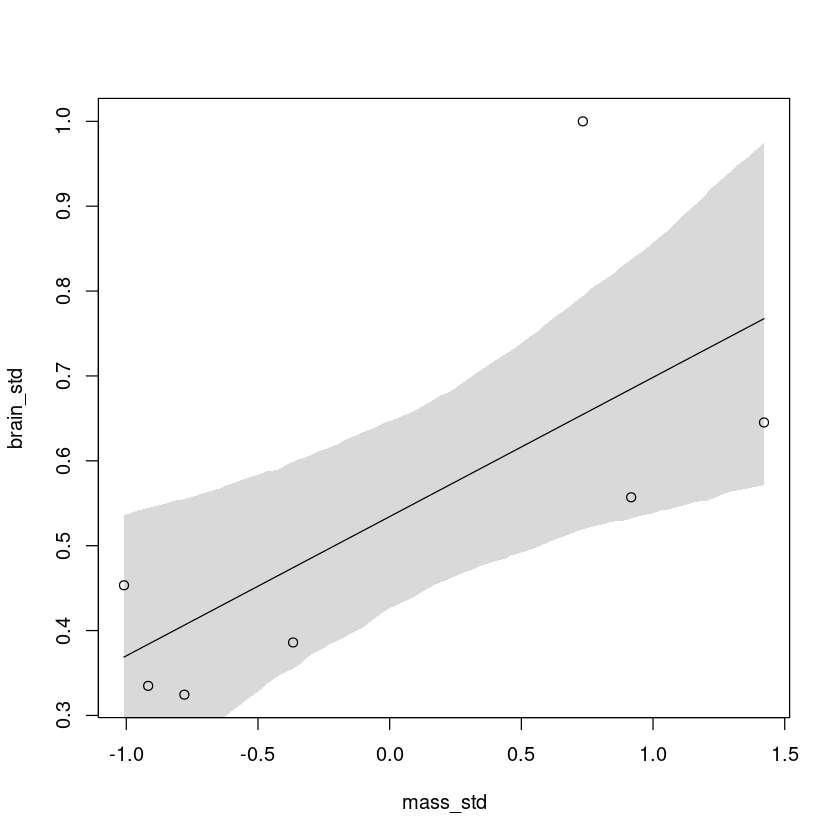

In [8]:
## R code 7.10
post <- extract.samples(m7.1)
mass_seq <- seq( from=min(d$mass_std) , to=max(d$mass_std) , length.out=100 )
l <- link( m7.1 , data=list( mass_std=mass_seq ) )
mu <- apply( l , 2 , mean )
ci <- apply( l , 2 , PI )
plot( brain_std ~ mass_std , data=d )
lines( mass_seq , mu )
shade( ci , mass_seq )

+ Plot of `n` order polynomial models fitted to the data where:
    + m7.1 - first order
    + m7.2 - second order
    + ...
    + m7.6 - sixth order
+ As model becomes more complex, model fits data better, and $R^2$ score improves - the model explains more of the variance
+ Black line is posterior mean
+ 89% interval is shaded
+ The six degree polynomial fits the data perfectly because it assigns each parameter to each data point
+ The lower degree polynomials are terrible fits

![alt text](images/7/overfitting-1.png "Title")

+ ### Leave One Out Process
+ Drop one row of the data
+ Fit the model
+ The most complex model swings about significantly.
+ The simplest model hardly moves

![alt text](images/7/overfitting-2.png "Title")

+ Bias and Variance - The tradeoff between under/overfitting. Not exactly the same, but
    + Bias relates to underfitting
    + Variance relates to Overfitting

# 7.2 Entropy and Accuracy

+ To score a Bayesian Analysis, we use the LOG SCORING RULE to assess how closely a model predicts probabilities compared to true probabilities - This is the log of the joint probability , where the joint probability is considered the likelihood. We can use this to compare models.
+ We use a measure of how much uncertainty is inherent in a probability distribution. This is the INFORMATION ENTROPY
    + $H(p) = -E \; log(p_i) = -\sum_{i=1}^n p_ilog(p_i)$
+ To assess how far away we are from perfect prediction, we use a divergence score - the Kullback-Leibler divergence, or KL divergence score.from a perfect score, 
+ [???? - This is a really convoluted section. Maybe author should start with conclusion and build an argument to get there. I am having trouble deciphering where the author finally lands - ie what scoring formula to use]
+ As far as I can tell, the author uses the following to score a model:
    + **LOG-POINTWISE-PREDICTIVE-DENSITY**
    + $lppd(y, \theta) = \sum_{i} log \frac{1}{S} \sum_S p(y_i | \theta_s)$
    + where:
        + $S$ is number of samples
        + $\theta_S$ is the posterior distribution
+ For the lppd, bigger is better
+ There is another formulation of lppd called DEVIANCE
    + $DEVIANCE = -2 \times lppd score$
    + For Deviance - smaller is better
+ To calculate the lppd scores in code:

In [9]:
## R code 7.13
set.seed(1)
lppd( m7.1 , n=1e4 )

[1]  0.6098668  0.6483438  0.5496093  0.6234934  0.4648143  0.4347605 -0.8444633

+ Or, laying out the code for the lppd calculation
+ These should be summed, though christ knows why the author wouldn't just sum them here in code

In [10]:
## R code 7.14
set.seed(1)
logprob <- sim( m7.1 , ll=TRUE , n=1e4 )
n <- ncol(logprob)
ns <- nrow(logprob)
f <- function( i ) log_sum_exp( logprob[,i] ) - log(ns)
( lppd <- sapply( 1:n , f ) )

[1]  0.6098668  0.6483438  0.5496093  0.6234934  0.4648143  0.4347605 -0.8444633

## Training and Test Set
+ Now that we have developed a score, we need to make sure we apply it to the correct part of the data
+ If we score the models as set up previously we get as below
+ But, this is irrelevant - What matters is how we score on unseen data

In [11]:
## R code 7.15
set.seed(1)
sapply( list(m7.1,m7.2,m7.3,m7.4,m7.5,m7.6) , function(m) sum(lppd(m)) )

[1]  2.490390  2.566165  3.741488  5.333750 14.124459 39.445390

+ The author runs a simulation to show how in-sample and out-of-sample deviance scores are impacted by parameters
+ The simulation is set up so that the data is generated from a 3 parameter function. Hence the 'correct' number of parameters is 3
+ N is the size of the training and test sample - 20 each, or 100 each
+ I don't get why he is calling this a deviance score - It is
    + $-2 \times lppd$

In [12]:
# Cannot get this to run !!
# Probably mcreplicate line
## R code 7.16
# N <- 20
# kseq <- 1:5
# dev <- sapply( kseq , function(k) {
#         print(k);
#         r <- mcreplicate( 1e4 , sim_train_test( N=N, k=k ) , mc.cores=4 )
#         c( mean(r[1,]) , mean(r[2,]) , sd(r[1,]) , sd(r[2,]) )
#     } )

In [13]:
# Cannot get code above to run, so this plot is defunct !!
## R code 7.18
# plot( 1:5 , dev[1,] , ylim=c( min(dev[1:2,])-5 , max(dev[1:2,])+10 ) ,
#     xlim=c(1,5.1) , xlab="number of parameters" , ylab="deviance" ,
#     pch=16 , col=rangi2 )
# mtext( concat( "N = ",N ) )
# points( (1:5)+0.1 , dev[2,] )
# for ( i in kseq ) {
#     pts_in <- dev[1,i] + c(-1,+1)*dev[3,i]
#     pts_out <- dev[2,i] + c(-1,+1)*dev[4,i]
#     lines( c(i,i) , pts_in , col=rangi2 )
#     lines( c(i,i)+0.1 , pts_out )
# }

![alt text](images/7/simulate-in-out-sample-scores.png "Title")

+ The conclusion of this is that the lowest out-of-sample Deviance is associated, in both scenarios - 20 or 100 sample size, with the 'correct' number of parameters - where 'correct' means the number of parameters that were used to generate the data

# Regularization

![alt text](images/7/regularizing-priors.png "Title")

regularizing-priors.png

![alt text](images/7/reg-priors-out-of-sample-deviance.png "Title")

reg-priors-out-of-sample-deviance.png



# 7.4 Predicting Predictive Accuracy

In [14]:
## R code 7.19
data(cars)
m <- quap(
    alist(
        dist ~ dnorm(mu,sigma),
        mu <- a + b*speed,
        a ~ dnorm(0,100),
        b ~ dnorm(0,10),
        sigma ~ dexp(1)
    ) , data=cars )
set.seed(94)
post <- extract.samples(m,n=1000)

## R code 7.20
n_samples <- 1000
logprob <- sapply( 1:n_samples ,
    function(s) {
        mu <- post$a[s] + post$b[s]*cars$speed
        dnorm( cars$dist , mu , post$sigma[s] , log=TRUE )
    } )

## R code 7.21
n_cases <- nrow(cars)
lppd <- sapply( 1:n_cases , function(i) log_sum_exp(logprob[i,]) - log(n_samples) )

## R code 7.22
pWAIC <- sapply( 1:n_cases , function(i) var(logprob[i,]) )

## R code 7.23
-2*( sum(lppd) - sum(pWAIC) )

## R code 7.24
waic_vec <- -2*( lppd - pWAIC )
sqrt( n_cases*var(waic_vec) )

[1] 423.3188

[1] 17.81797

# 7.5 Model Comparison

In [15]:
# Code from last chapter used as models in this chapter
## R code 6.13
set.seed(71)
# number of plants
N <- 100

# simulate initial heights
h0 <- rnorm(N,10,2)

# assign treatments and simulate fungus and growth
treatment <- rep( 0:1 , each=N/2 )
fungus <- rbinom( N , size=1 , prob=0.5 - treatment*0.4 )
h1 <- h0 + rnorm(N, 5 - 3*fungus)

# compose a clean data frame
d <- data.frame( h0=h0 , h1=h1 , treatment=treatment , fungus=fungus )
precis(d)

## R code 6.14
sim_p <- rlnorm( 1e4 , 0 , 0.25 )
precis( data.frame(sim_p) )

## R code 6.15
m6.6 <- quap(
    alist(
        h1 ~ dnorm( mu , sigma ),
        mu <- h0*p,
        p ~ dlnorm( 0 , 0.25 ),
        sigma ~ dexp( 1 )
    ), data=d )
precis(m6.6)

## R code 6.16
m6.7 <- quap(
    alist(
        h1 ~ dnorm( mu , sigma ),
        mu <- h0 * p,
        p <- a + bt*treatment + bf*fungus,
        a ~ dlnorm( 0 , 0.2 ) ,
        bt ~ dnorm( 0 , 0.5 ),
        bf ~ dnorm( 0 , 0.5 ),
        sigma ~ dexp( 1 )
    ), data=d )
precis(m6.7)

## R code 6.17
m6.8 <- quap(
    alist(
        h1 ~ dnorm( mu , sigma ),
        mu <- h0 * p,
        p <- a + bt*treatment,
        a ~ dlnorm( 0 , 0.2 ),
        bt ~ dnorm( 0 , 0.5 ),
        sigma ~ dexp( 1 )
    ), data=d )
precis(m6.8)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
h0,9.95978,2.1011623,6.570328,13.07874,▁▂▂▂▇▃▂▃▁▁▁▁
h1,14.39920,2.6880870,10.618002,17.93369,▁▁▃▇▇▇▁▁
treatment,0.50000,0.5025189,0.000000,1.00000,▇▁▁▁▁▁▁▁▁▇
fungus,0.23000,0.4229526,0.000000,1.00000,▇▁▁▁▁▁▁▁▁▂


,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
sim_p,1.03699,0.2629894,0.670683,1.496397,▁▁▃▇▇▃▁▁▁▁▁▁


,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
p,1.426626,0.01760992,1.398482,1.454770
sigma,1.793286,0.12517262,1.593236,1.993336


,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.481391468,0.02451069,1.44221865,1.52056429
bt,0.002412222,0.02986965,-0.04532525,0.05014969
bf,-0.266718915,0.03654772,-0.32512923,-0.20830860
sigma,1.408797442,0.09862070,1.25118251,1.56641237


,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.38035767,0.02517554,1.34012229,1.4205931
bt,0.08499924,0.03429718,0.03018573,0.1398128
sigma,1.74631655,0.12191552,1.55147200,1.9411611


WAIC,lppd,penalty,std_err
<dbl>,<dbl>,<dbl>,<dbl>
361.4511,-177.1724,3.553198,14.17033


,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m6.7,361.8901,14.26190,0.00000,NA,3.839491,1.000000e+00
m6.8,402.7757,11.28257,40.88562,10.47837,2.645879,1.323732e-09
m6.6,405.9139,11.64641,44.02380,12.22582,1.581312,2.756471e-10


[1] 10.3581

[1] 12.96 67.04

[1] 4.854575

,m6.6,m6.7,m6.8
m6.6,NA,12.20191,4.930467
m6.7,12.201914,NA,10.426817
m6.8,4.930467,10.42682,NA


Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.



,PSIS,SE,dPSIS,dSE,pPSIS,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m5.1,127.5665,14.69485,0.000000,NA,4.671425,0.8340176286
m5.3,130.8062,16.15696,3.239685,1.808671,6.578663,0.1650769863
m5.2,141.2178,11.56557,13.651299,10.923820,4.057204,0.0009053851


Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.



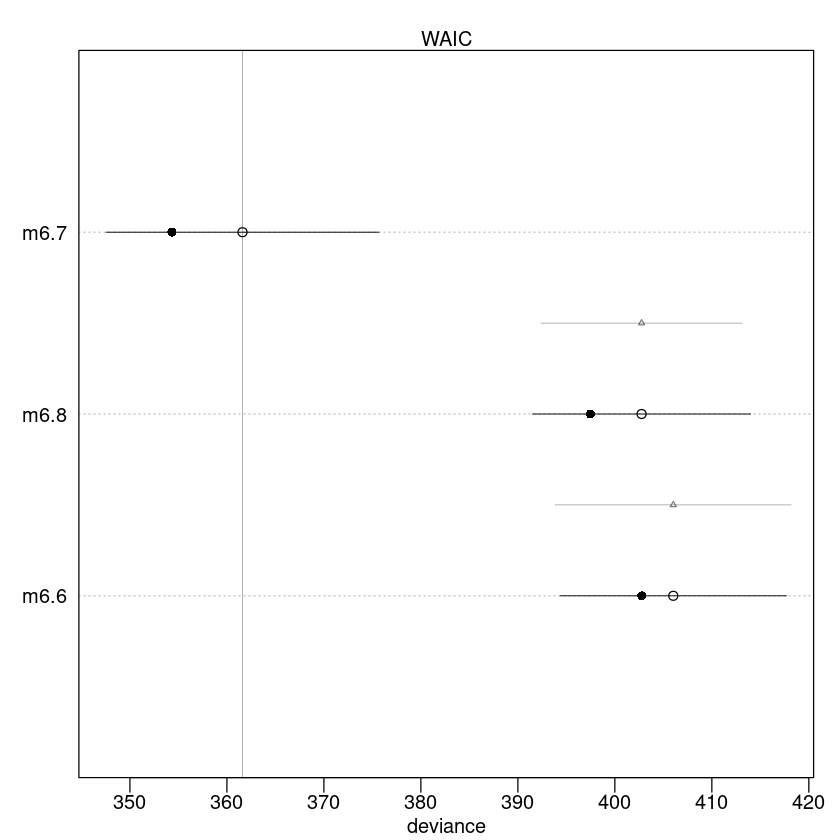

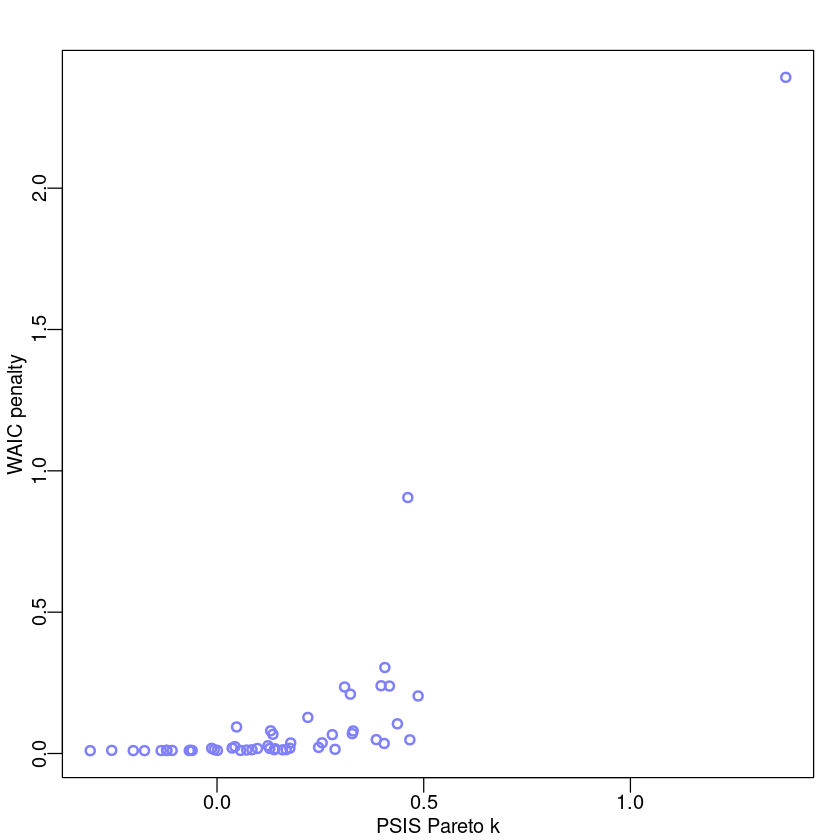

In [16]:
## R code 7.25
set.seed(11)
WAIC( m6.7 )

## R code 7.26
set.seed(77)
compare( m6.6 , m6.7 , m6.8 , func=WAIC )

## R code 7.27
set.seed(91)
waic_m6.7 <- WAIC( m6.7 , pointwise=TRUE )$WAIC
waic_m6.8 <- WAIC( m6.8 , pointwise=TRUE )$WAIC
n <- length(waic_m6.7)
diff_m6.7_m6.8 <- waic_m6.7 - waic_m6.8
sqrt( n*var( diff_m6.7_m6.8 ) )

## R code 7.28
40.0 + c(-1,1)*10.4*2.6

## R code 7.29
plot( compare( m6.6 , m6.7 , m6.8 ) )

## R code 7.30
set.seed(92)
waic_m6.6 <- WAIC( m6.6 , pointwise=TRUE )$WAIC
diff_m6.6_m6.8 <- waic_m6.6 - waic_m6.8
sqrt( n*var( diff_m6.6_m6.8 ) )

## R code 7.31
set.seed(93)
compare( m6.6 , m6.7 , m6.8 )@dSE

## R code 7.32
library(rethinking)
data(WaffleDivorce)
d <- WaffleDivorce
d$A <- standardize( d$MedianAgeMarriage )
d$D <- standardize( d$Divorce )
d$M <- standardize( d$Marriage )

m5.1 <- quap(
    alist(
        D ~ dnorm( mu , sigma ) ,
        mu <- a + bA * A ,
        a ~ dnorm( 0 , 0.2 ) ,
        bA ~ dnorm( 0 , 0.5 ) ,
        sigma ~ dexp( 1 )
    ) , data = d )

m5.2 <- quap(
    alist(
        D ~ dnorm( mu , sigma ) ,
        mu <- a + bM * M ,
        a ~ dnorm( 0 , 0.2 ) ,
        bM ~ dnorm( 0 , 0.5 ) ,
        sigma ~ dexp( 1 )
    ) , data = d )

m5.3 <- quap(
    alist(
        D ~ dnorm( mu , sigma ) ,
        mu <- a + bM*M + bA*A ,
        a ~ dnorm( 0 , 0.2 ) ,
        bM ~ dnorm( 0 , 0.5 ) ,
        bA ~ dnorm( 0 , 0.5 ) ,
        sigma ~ dexp( 1 )
    ) , data = d )

## R code 7.33
set.seed(24071847)
compare( m5.1 , m5.2 , m5.3 , func=PSIS )

## R code 7.34
set.seed(24071847)
PSIS_m5.3 <- PSIS(m5.3,pointwise=TRUE)
set.seed(24071847)
WAIC_m5.3 <- WAIC(m5.3,pointwise=TRUE)
plot( PSIS_m5.3$k , WAIC_m5.3$penalty , xlab="PSIS Pareto k" ,
    ylab="WAIC penalty" , col=rangi2 , lwd=2 )

## R code 7.35
m5.3t <- quap(
    alist(
        D ~ dstudent( 2 , mu , sigma ) ,
        mu <- a + bM*M + bA*A ,
        a ~ dnorm( 0 , 0.2 ) ,
        bM ~ dnorm( 0 , 0.5 ) ,
        bA ~ dnorm( 0 , 0.5 ) ,
        sigma ~ dexp( 1 )
    ) , data = d )